<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quite Complex Simulation

### Inevitable Imports

In [0]:
import scipy.integrate as integrate # for numerical solution od differential equations
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices
import math as math

simulatedObjects = []

### Display functions 

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


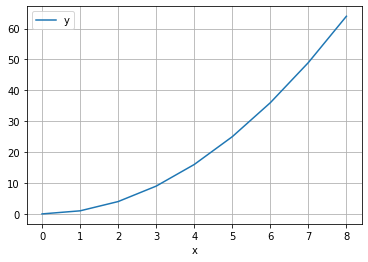

In [3]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

### Operators on Data Streams

In [4]:
def skip(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        next(innerGen)
    except StopIteration:
        pass
  return innerGen

def take(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        yield next(innerGen)
    except StopIteration:
        pass
  

def dilute(generator, ratio):
  innerGen = iter(generator)
  while True:
    skip(innerGen, ratio - 1)
    try:
        yield next(innerGen)
    except StopIteration:
        return

#=================#
# example of use  #
#=================#
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
partOfData = take(skip(data, 5), 2) # skip five, take two next, rest blow up
dilutedData = dilute(data, 2) # every odd
displayData(data)
displayData(partOfData)
displayData(dilutedData)


,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


,x,y
0,5,25
1,6,36


,x,y
0,1,1
1,3,9
2,5,25
3,7,49


### Some Theory 
$\left( y=f(x)  \right)$

### Compute One Step function

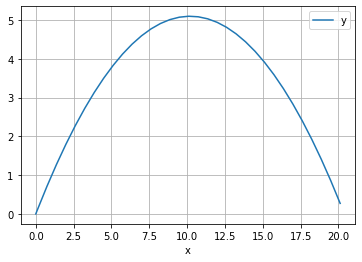

In [5]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    yield currentItem # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

### Prepare and Simulate

In [0]:
def prepareSimulation(systemList, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  for system in systemList:
    system['solver'] = compute(system['model'], system['state0'], t0 = t0, t_bound = t_bound, max_step = max_step)
    system['finished'] = False
    system['result'] = next(system['solver'])#system['state0']

def simulate(systemList):
  for system in systemList:
    if system['finished'] == False:
      system['result'] = next(system['solver'])

### Nearly Infinite Simulation

In [0]:
def simulateInf(systemList, count = -1):
  cc = count
  while True:
    simulate(systemList)
    partialResult = {}
    for system in systemList:
      partialResult[system['name']] = {**system}
    yield partialResult
    cc = cc - 1
    if cc == 0:
      break # maximum steps reached, break it


### Example of Single System Simulation

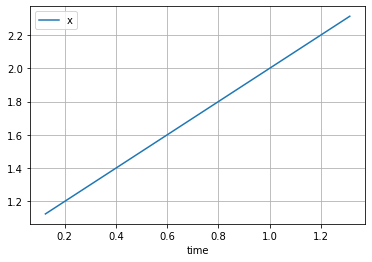

In [8]:
def movingObj(time, state):
  velocity = state[:3]
  position = state[3:]
  acceleration = [0, 0, 0]
  return [*acceleration, *velocity]

def rearangeResults(results, selectors):
  for result in results:
    partialResult = {}
    for selector in selectors:
      partialResult[selector['name']] = selector['selector'](result)
    yield partialResult

simulatedObjects = [{'state0': [1, 0.75, 0, 1, 1, 0], 'model': movingObj, 'name': 'obj1'}]
prepareSimulation(simulatedObjects)
simResults = list(simulateInf(simulatedObjects, 20))
simResultsRearanged = list(rearangeResults(simResults, 
  [
   {'name': 'time', 'selector': lambda item: item['obj1']['result']['time']},
   {'name': 'x', 'selector': lambda item: item['obj1']['result']['y'][3]},
   {'name': 'y', 'selector': lambda item: item['obj1']['result']['y'][4]}
   ]))

#simResults = list(justTwoFromResults(simResults, 'obj1', x = 3, y = 4))
#displayData(simResultsRearanged)
plotData(simResultsRearanged)#, x = 'x', y = 'y')
plt.grid(which='both')

### More Complex Simulation

#### Plane Model

In [0]:
def createPlaneModel(input):
  def planeModel(time, state):
    currentInput = input()
    
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput)

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs

    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return planeModel

#### Rocket Model

|symbol|meaning|
|-|-|
|$\vec r_r$ | missile to target destination |
|$\vec v_r$ | missile to target velocity |
| $n$ | control gain (3-5)|
|$\vec v_m$| absolute velocity of missile |


vector form of $\omega = \frac {v}{r}$

$\vec \omega = \frac {\vec r_r \times \vec v_r }{ \vec r_r \cdot \vec r_r }$

$\vec a = -n|\vec v_r|\frac{\vec v_m}{|\vec v_m|} \times \vec \omega$



In [10]:
def createRocketModel(rocketSystem, systemToDestroy, n = 3):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']

    currentPosition = np.array(state[3:])
    currentVelocity = np.array(state[:3])

    targetPosition = np.array(currentInput[3:])
    targetVelocity  = np.array(currentInput[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector

    positionR = targetPosition - currentPosition
    positionRAbs = np.linalg.norm(positionR) # abs of vector
    velocityR = targetVelocity - currentVelocity
    velocityRAbs = np.linalg.norm(velocityR) # abs of vector

    omega = 1 / positionRAbs / positionRAbs * np.cross(positionR, velocityR)

    neededAcceleration = -n * velocityRAbs / currentVelocityAbs * \
      np.cross(currentVelocity, omega)
    result = [*neededAcceleration, *currentVelocity]

    if positionRAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    return result
  return rocketModel

"""
def createRocketModelAx02(rocketSystem, systemToDestroy, n = 1):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetVelocity = np.array(currentInput[:3])
    targetPosition = np.array(currentInput[3:])


    relativeVelocity = currentVelocity - targetVelocity
    relativeVelocityAbs = np.linalg.norm(relativeVelocity)
    relativeDistance = currentPosition - targetPosition
    relativeDistanceAbs = np.linalg.norm(relativeDistance)
    timeToHit = relativeDistanceAbs / relativeVelocityAbs
    predictedTargetPosition = targetPosition + timeToHit * targetVelocity

    ####### !!!!!!!!!!!!!!! ###########
    wantedVelocity = predictedTargetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if relativeDistanceAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*(neededAcceleration * n), *currentVelocity]
    return result
  return rocketModel


def createRocketModel02(rocketSystem, systemToDestroy, n = 1):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetVelocity = np.array(currentInput[:3])
    targetPosition = np.array(currentInput[3:])

    ####### !!!!!!!!!!!!!!! ###########
    wantedVelocity = targetVelocity + targetPosition - currentPosition

    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if wantedVelocityAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*(neededAcceleration * n), *currentVelocity]
    return result
  return rocketModel



def createRocketModelOld(rocketSystem, systemToDestroy):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput[3:])

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if wantedVelocityAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return rocketModel
"""

"\ndef createRocketModelAx02(rocketSystem, systemToDestroy, n = 1):\n  localData = {'rocket': rocketSystem, 'target': systemToDestroy}\n  def rocketModel(time, state):\n    if localData['rocket']()['finished']:\n      return [0, 0, 0, 0, 0, 0]\n\n    currentInput = localData['target']()['result']['y']\n    #print('currentInput', currentInput)\n    currentVelocity = np.array(state[:3])\n    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector\n    \n    currentPosition = np.array(state[3:])\n    targetVelocity = np.array(currentInput[:3])\n    targetPosition = np.array(currentInput[3:])\n\n\n    relativeVelocity = currentVelocity - targetVelocity\n    relativeVelocityAbs = np.linalg.norm(relativeVelocity)\n    relativeDistance = currentPosition - targetPosition\n    relativeDistanceAbs = np.linalg.norm(relativeDistance)\n    timeToHit = relativeDistanceAbs / relativeVelocityAbs\n    predictedTargetPosition = targetPosition + timeToHit * targetVelocity\n\n    ####### !!!!

In [0]:
def createFixedTarget(x, y, z):
  def fixedPoint():
    return [x, y, z]
  return fixedPoint

#### Simulation Output

,time,plane_x,plane_y,plane_z,plane_f,rocket_x,rocket_y,rocket_z,rocket_f
0,0.450318,-31.389699,4.861720,999.513828,False,548.143916,-498.280005,3.575908,False
1,1.075318,-48.485185,17.354363,998.264564,False,692.271575,-473.276770,55.118644,False
2,1.700318,-52.443650,29.200254,997.079975,False,804.313493,-425.176073,151.469931,False
3,2.325318,-50.923419,39.150543,996.084946,False,873.284287,-361.219502,275.329437,False
4,2.950318,-46.916066,47.641584,995.235842,False,894.319831,-288.482685,411.269334,False
5,3.575318,-41.704987,55.223754,994.477625,False,868.097842,-213.855005,545.361549,False
6,4.200318,-35.886028,62.282624,993.771738,False,800.189574,-143.221620,666.466459,False
7,4.825318,-29.752054,69.050739,993.094926,False,699.341552,-80.645552,767.530731,False
8,5.450318,-23.452390,75.660121,992.433988,False,575.198013,-28.015317,845.965760,False
9,6.075318,-17.064851,82.183622,991.781638,False,436.351455,14.766634,903.021637,False


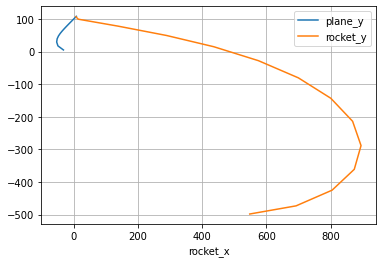

In [12]:
simulatedObjects = []
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1],
    systemToDestroy = lambda : simulatedObjects[0])

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 2000, max_step = 0.0625)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_z', 'selector': lambda item: item['plane']['result']['y'][5]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_z', 'selector': lambda item: item['rocket']['result']['y'][5]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
toHitData = list(filter(lambda item: not item['plane_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
plt.grid(which='both')

#### 3D Output

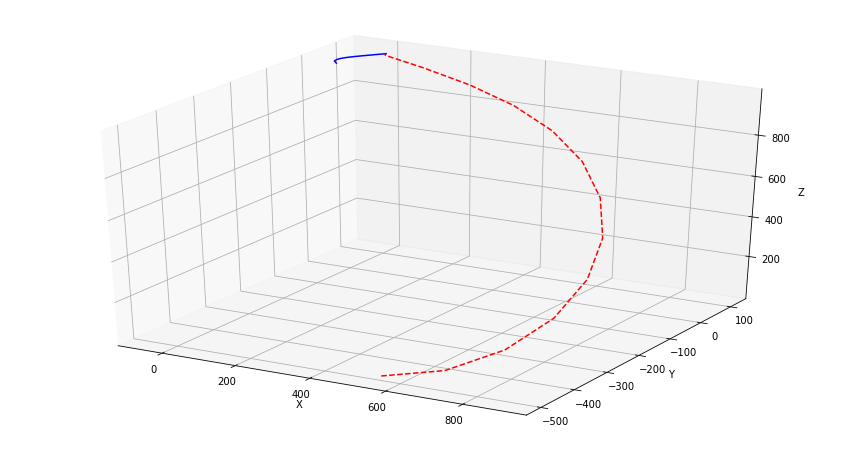

In [13]:
def selectValue(data, names):
  results = []
  for name in names:
    partialResult = []
    for item in data:
      partialResult.append(item[name])
    results.append(partialResult)
  return tuple(results)

plane_x, plane_y, plane_z = \
  selectValue(toHitData, ['plane_x', 'plane_y', 'plane_z'])
rocket_x, rocket_y, rocket_z = \
  selectValue(toHitData, ['rocket_x', 'rocket_y', 'rocket_z'])
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(plane_x, plane_y, plane_z, "b-")
gph.plot(rocket_x, rocket_y, rocket_z, "r--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()

### Three System Simulation

Rocket was not destroyed, plane was shooted down.

,time,plane_x,plane_y,plane_z,plane_f,rocket_x,rocket_y,rocket_z,rocket_f,antirocket_x,antirocket_y,antirocket_z,antirocket_f
0,0.231568,-19.127368,1.542683,999.845732,False,535.158404,-498.946809,2.153597,False,52.857021,0.002271,500.004905,False
1,0.544068,-35.369312,6.582908,999.341709,False,610.386111,-490.060525,20.400342,False,130.981066,0.122036,500.301084,False
2,0.856568,-44.650011,12.862027,998.713797,False,678.941817,-473.708283,53.755003,False,209.086976,0.649352,501.851318,False
3,1.169068,-49.641599,19.244076,998.075592,False,738.562094,-451.332035,98.800962,False,287.104933,1.684740,505.721911,False
4,1.481568,-51.926075,25.271409,997.472859,False,787.827972,-424.076045,152.810262,False,364.904110,2.932382,512.672810,False
5,1.794068,-52.460840,30.808983,996.919102,False,825.790312,-392.947484,213.460979,False,442.330016,3.563510,523.027738,False
6,2.106568,-51.839137,35.864922,996.413508,False,851.852288,-358.895550,278.660695,False,519.234944,1.978697,536.625918,False
7,2.419068,-50.437545,40.502412,995.949759,False,865.745206,-322.840409,346.466937,False,595.355300,-4.646937,552.774080,False
8,2.731568,-48.500806,44.798340,995.520166,False,867.526900,-285.671517,415.073142,False,669.623183,-21.093332,570.162225,False
9,3.044068,-46.191497,48.825384,995.117462,False,857.572468,-248.228704,482.832331,False,737.940285,-54.486083,586.774425,False


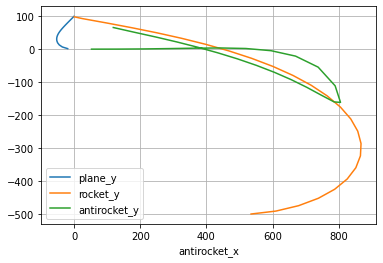

In [14]:
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocketTarget = lambda : simulatedObjects[0]['state']['state'][3:] 
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1], 
    systemToDestroy = lambda : simulatedObjects[0], 
    )
antiRocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[2], 
    systemToDestroy = lambda : simulatedObjects[1], 
    )

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  {'state0': [250, 0, 0, 0, 0, 500], 'model': antiRocket, 'name': 'antiRocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.03125)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_z', 'selector': lambda item: item['plane']['result']['y'][5]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_z', 'selector': lambda item: item['rocket']['result']['y'][5]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  {'name': 'antirocket_x', 'selector': lambda item: item['antiRocket']['result']['y'][3]},
  {'name': 'antirocket_y', 'selector': lambda item: item['antiRocket']['result']['y'][4]},
  {'name': 'antirocket_z', 'selector': lambda item: item['antiRocket']['result']['y'][5]},
  {'name': 'antirocket_f', 'selector': lambda item: item['antiRocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
#displayData(reData)
#ax = plotData(reData, x = 'plane_x', y = 'plane_y')
#ax = plotData(reData, x = 'rocket_x', y = 'rocket_y', ax = ax)
#ax = plotData(reData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)

toHitData = list(filter(lambda item: not item['rocket_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
ax = plotData(toHitData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)
plt.grid(which='both')

#### 3D Plot

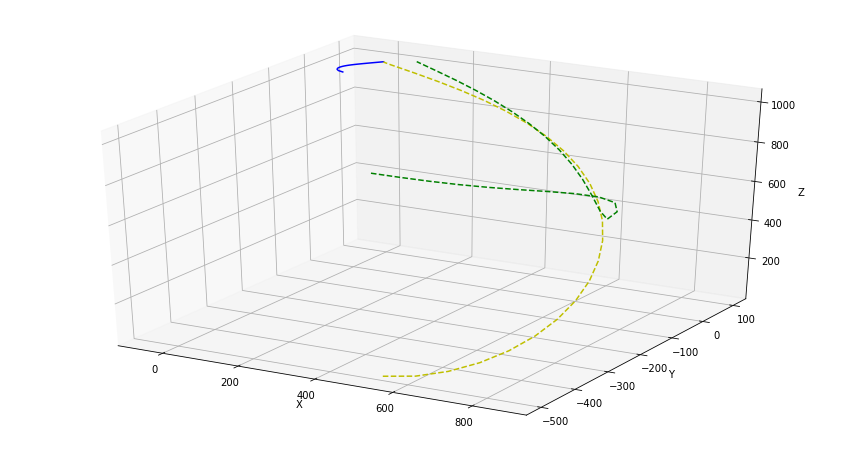

In [15]:
def selectValue(data, names):
  results = []
  for name in names:
    partialResult = []
    for item in data:
      partialResult.append(item[name])
    results.append(partialResult)
  return tuple(results)

plane_x, plane_y, plane_z = \
  selectValue(toHitData, ['plane_x', 'plane_y', 'plane_z'])
rocket_x, rocket_y, rocket_z = \
  selectValue(toHitData, ['rocket_x', 'rocket_y', 'rocket_z'])
antirocket_x, antirocket_y, antirocket_z = \
  selectValue(toHitData, ['antirocket_x', 'antirocket_y', 'antirocket_z'])

gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(plane_x, plane_y, plane_z, "b-")
gph.plot(rocket_x, rocket_y, rocket_z, "y--")
gph.plot(antirocket_x, antirocket_y, antirocket_z, "g--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()

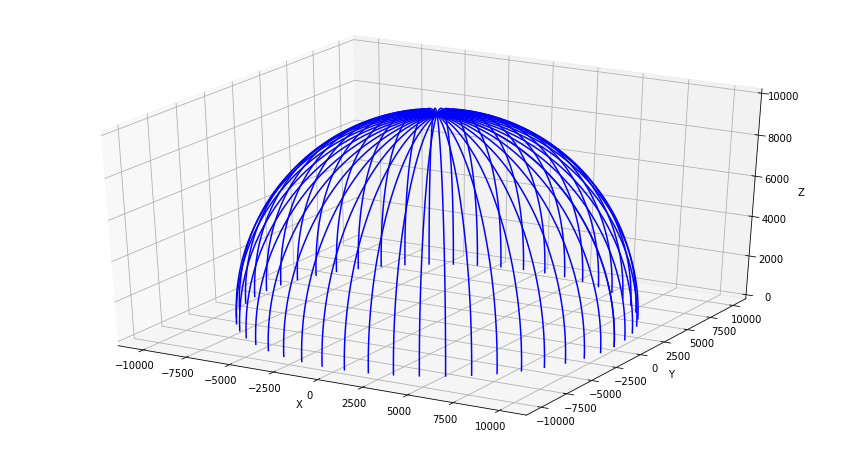

In [30]:
from math import pi, sin, cos

def angles(start, end, count = 50):
  delta = (end - start) / count
  for i in range(count + 1):
    yield start + i * delta

def segment(alpha, radius):
  for beta in angles(0, pi / 2):
    result = {
        'x': radius * cos(alpha) * cos(beta), 
        'y': radius * sin(alpha) * cos(beta),
        'z': radius * sin(beta),
        }
    #print(result)
    yield result

radius = 10000
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
for alpha in angles(0, 2 * pi):
  s = list(segment(alpha, radius))
  x = list(map(lambda item: item['x'], s))
  y = list(map(lambda item: item['y'], s))
  z = list(map(lambda item: item['z'], s))
  gph.plot(x, y, z, "b-")
  #break

gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()
